In [1]:
%pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/repo.html
%pip install labml-nn

Looking in links: https://data.dgl.ai/wheels/torch-2.3/repo.html
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F


class LinearNeuralNetwork(nn.Module):
    def __init__(self, nfeat, nclass, bias=True):
        super(LinearNeuralNetwork, self).__init__()
        self.W = nn.Linear(nfeat, nclass, bias=bias)

    def forward(self, x):
        return self.W(x)


def symmetric_normalize_adjacency(graph):
    """Symmetric normalize graph adjacency matrix."""
    indices = torch.stack(graph.edges())
    n = graph.num_nodes()
    adj = dglsp.spmatrix(indices, shape=(n, n))
    deg_invsqrt = dglsp.diag(adj.sum(0)) ** -0.5
    return deg_invsqrt @ adj @ deg_invsqrt


def model_test(model, embeds):
    model.eval()
    with torch.no_grad():
        output = model(embeds)
        pred = output.argmax(dim=-1)
        test_mask, tv_mask = model.test_mask, model.tv_mask
        loss_tv = F.mse_loss(output[tv_mask], model.label_one_hot[tv_mask])
    accs = []
    for mask in [tv_mask, test_mask]:
        accs.append(
            float((pred[mask] == model.label[mask]).sum() / mask.sum()))
    return loss_tv.item(), accs[0], accs[1], pred

c:\Users\Taneem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
c:\Users\Taneem\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import dgl.sparse as dglsp
import torch.nn as nn
import torch.nn.functional as F


class OGC(nn.Module):
    def __init__(self, graph):
        super(OGC, self).__init__()
        self.linear_clf = LinearNeuralNetwork(
            nfeat=graph.ndata["feat"].shape[1],
            nclass=graph.ndata["label"].max().item() + 1,
            bias=False,
        )

        self.label = graph.ndata["label"]
        self.label_one_hot = F.one_hot(graph.ndata["label"]).float()
        # LIM trick, else use both train and val set to construct this matrix.
        self.label_idx_mat = dglsp.diag(graph.ndata["train_mask"]).float()

        self.test_mask = graph.ndata["test_mask"]
        self.tv_mask = graph.ndata["train_mask"] + graph.ndata["val_mask"]

    def forward(self, x):
        return self.linear_clf(x)

    def update_embeds(self, embeds, lazy_adj, args):
        """Update classifier's weight by training a linear supervised model."""
        pred_label = self(embeds).data
        clf_weight = self.linear_clf.W.weight.data

        # Update the smoothness loss via LGC.
        embeds = dglsp.spmm(lazy_adj, embeds)

        # Update the supervised loss via SEB.
        deriv_sup = 2 * dglsp.matmul(
            dglsp.spmm(self.label_idx_mat, -self.label_one_hot + pred_label),
            clf_weight,
        )
        embeds = embeds - args.lr_sup * deriv_sup  # Eq. 6

        args.lr_sup = args.lr_sup * args.decline
        return embeds

In [4]:
import argparse
import time

import dgl.sparse as dglsp

import torch.nn.functional as F
import torch.optim as optim
from dgl import AddSelfLoop
from dgl.data import CiteseerGraphDataset

parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.dataset = "citeseer"
args.decline = 0.9
args.lr_sup = 0.001
args.lr_clf = 0.5
args.beta = 0.1
args.max_sim_rate = 0.995
args.max_patience = 2
args.device = torch.device("cpu")

In [5]:
def train(model, embeds, lazy_adj, args):
    patience = 0
    _, _, last_acc, last_output = model_test(model, embeds)

    tv_mask = model.tv_mask
    optimizer = optim.SGD(model.parameters(), lr=args.lr_clf)

    for i in range(64):
        model.train()
        output = model(embeds)
        loss_tv = F.mse_loss(
            output[tv_mask], model.label_one_hot[tv_mask], reduction="sum"
        )
        optimizer.zero_grad()
        loss_tv.backward()
        optimizer.step()

        # Updating node embeds by LGC and SEB jointly.
        embeds = model.update_embeds(embeds, lazy_adj, args)

        loss_tv, acc_tv, acc_test, pred = model_test(model, embeds)
        print(
            "epoch {} loss_tv {:.4f} acc_tv {:.4f} acc_test {:.4f}".format(
                i + 1, loss_tv, acc_tv, acc_test
            )
        )

        sim_rate = float(int((pred == last_output).sum()) / int(pred.shape[0]))
        if sim_rate > args.max_sim_rate:
            patience += 1
            if patience > args.max_patience:
                break
        last_acc = acc_test
        last_output = pred
    return last_acc

In [6]:
transform = AddSelfLoop()
data = CiteseerGraphDataset(transform=transform)
graph = data[0].to(args.device)

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
graph.has_edges_between([0], [1])

tensor([False])

In [8]:
features = graph.ndata["feat"]
adj = symmetric_normalize_adjacency(graph)
I_N = dglsp.identity((features.shape[0], features.shape[0]))
print(I_N)
# Lazy random walk (also known as lazy graph convolution).
lazy_adj = dglsp.add((1 - args.beta) * I_N, args.beta * adj).to(args.device)
print(lazy_adj)

SparseMatrix(indices=tensor([[   0,    1,    2,  ..., 3324, 3325, 3326],
                             [   0,    1,    2,  ..., 3324, 3325, 3326]]),
             values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             shape=(3327, 3327), nnz=3327)
SparseMatrix(indices=tensor([[   0,    0,    1,  ..., 3325, 3326, 3326],
                             [   0,  628,    1,  ..., 3325,   33, 3326]]),
             values=tensor([0.9500, 0.0500, 0.9167,  ..., 0.9500, 0.0289, 0.9500]),
             shape=(3327, 3327), nnz=12431)


In [9]:
model = OGC(graph).to(args.device)

In [10]:
sum(p.numel() for p in model.parameters())

22218

In [11]:

# start_time = time.time()
# res = train(model, features, lazy_adj, args)
# time_tot = time.time() - start_time

# print(f"Test Acc:{res:.4f}")
# print(f"Total Time:{time_tot:.4f}")

In [12]:
import numpy as np

test_accs = []
total_times = []

for run in range(20):
    print(f"\nRun {run + 1}/20")

    # Reload fresh graph and features
    transform = AddSelfLoop()
    data = CiteseerGraphDataset(transform=transform)
    graph = data[0].to(args.device)

    features = graph.ndata["feat"].to(args.device)
    adj = symmetric_normalize_adjacency(graph).to(args.device)

    # Reset args
    args.lr_sup = 0.001  # fresh value!

    # New model
    model = OGC(graph).to(args.device)

    optimizer = optim.SGD(model.parameters(), lr=args.lr_clf)

    start_time = time.time()
    test_acc = train(model, features, lazy_adj, args)
    time_tot = time.time() - start_time

    test_accs.append(test_acc)
    total_times.append(time_tot)

# Calculate statistics
test_accs = np.array(test_accs) * 100  # Convert to percentage
mean_acc = np.mean(test_accs)
std_acc = np.std(test_accs)

print(f"Test Acc: {mean_acc:.1f}±{std_acc:.1f}")
print(f"Average Time: {np.mean(total_times):.4f}s")


Run 1/20
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
epoch 1 loss_tv 0.1134 acc_tv 0.7758 acc_test 0.6500
epoch 2 loss_tv 0.0945 acc_tv 0.8258 acc_test 0.7050
epoch 3 loss_tv 0.0799 acc_tv 0.8677 acc_test 0.7300
epoch 4 loss_tv 0.0689 acc_tv 0.8790 acc_test 0.7360
epoch 5 loss_tv 0.0610 acc_tv 0.8968 acc_test 0.7510
epoch 6 loss_tv 0.0553 acc_tv 0.9081 acc_test 0.7620
epoch 7 loss_tv 0.0512 acc_tv 0.9129 acc_test 0.7630
epoch 8 loss_tv 0.0482 acc_tv 0.9113 acc_test 0.7670
epoch 9 loss_tv 0.0458 acc_tv 0.9129 acc_test 0.7690
epoch 10 loss_tv 0.0439 acc_tv 0.9177 acc_test 0.7680
epoch 11 loss_tv 0.0423 acc_tv 0.9161 acc_test 0.7730
epoch 12 loss_tv 0.0410 acc_tv 0.9194 acc_test 0.7750
epoch 13 loss_tv 0.0399 acc_tv 0.9258 acc_test 0.7740
epoch 14 loss_tv 0.0389 acc_tv 0.9242 acc_test 0.7750
epoch 15 loss_tv 0.0381 acc_tv 0.9242 acc_test 0.7760
epoch 16

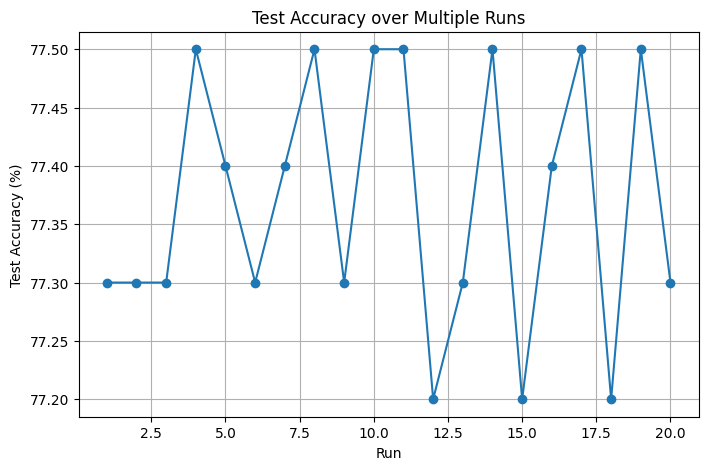

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(test_accs) + 1), test_accs, marker='o')
plt.title("Test Accuracy over Multiple Runs")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()